## Тематическое моделирование. EM-алгоритм



Построим тематические модели для корпуса новостей Lenta.ru, с которым мы уже работали ранее.

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
!pip install corus

In [3]:
from corus import load_lenta
path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество',
    date=None
)

In [4]:
data = [(record.title, record.topic, record.text, record.tags) for record in records]

In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [6]:
data = pd.DataFrame(data, columns=['title','topic','text','tags'])

In [7]:
data.sample(3)

,title,topic,text,tags
349249,Вексельберг станет крупнейшим отельером Сочи,Дом,"Компания ""Ренова-Стройгруп"" (входит в холдинг ""Ренова"" Виктора Вексельберга) приступила к строительству многофункционального гостиничного комплекса на 3600 номеровв Адлерском районе Сочи Как пишет газета ""РБК daily"", комплекс в Имеретинской низменности станет крупнейшим гостиничным олимпийским объектом.По данным издания, квартал будет построен на участке площадью 34,5 гектара, который ранее был зарезервирован за структурами бывшего владельца Черкизовского рынка, основателя группы АСТ Тельмана Исмаилова. Газета отмечает, что Исмаилов выбыл из числа застройщиков олимпийских объектов из-за финансовых трудностей.Многофункциональный комплекс (МФК) ""Реновы-Стройгруп"" будет включать в себя гостиницу и апарт-отель класса три или четыре звезды под брендом Park Inn (оператор — сеть Rezidor Hotel Group), торгово-развлекательные центры, рестораны, кинотеатр, аквапарк, спортивный комплекс, конференц-зал. Общая площадь МФК составит 183 тысячи квадратных метров. По информации РИА Новости, курорт будет функционировать с пиковыми нагрузками летом и зимой, а в межсезонье будет заполняться, прежде всего, за счет корпоративных мероприятий.Девелопером проекта, инвестиции в который составят 600 миллионов долларов, является компания Top Project (входит в ""Ренова-Стройгруп""). Более половины этой суммы компания получит в виде кредита от Внешэкономбанка. Строительство МФК должно завершиться в начале лета 2013 года.Для ""Ренова-Стройгруп"" этот проект станет дебютным на гостиничном рынке. В настоящее время компания специализируется на реализации крупных проектов на рынке жилой недвижимости (в Екатеринбурге, Челябинске, Перми, Ярославле, Краснодаре и Московской области) и строительстве коммерческой недвижимости. Общий портфель проектов девелопера составляет около 20 миллионов квадратных метров недвижимости.В Сочи к зимней Олимпиаде 2014 года планируется построить гостиницы на 12,5 тысячи номеров различного уровня. Крупный отельный кластер будет расположен на территории спортивно-туристического комплекса ""Горная Карусель"". Здесь, в частности, планируется открыть люксовые отели 4 ведущих мировых сетей на 1315 номеров.",Все
563278,Столица Сомали взбунтовалась против эфиопских войск,Мир,"Тысячи жителей столицы Сомали Могадишо вышли на демонстрацию против присутствия в стране армии Эфиопии, которая поддержала переходное правительство в войне с боевиками радикального Союза исламских судов, сообщает AFP. По словам очевидцев, акции протеста проходят в северной части города. Демонстранты выкрикивают лозунги против оккупации страны эфиопами и бросают камни. Подожжены автомобильные покрышки. Напомним, что сомалийские правительственные войска при поддержке армии Эфиопии вошли в Могадишо 28 декабря после десяти дней активных боевых действий, в ходе которых от исламистов были очищены 95 процентов территории Сомали. По официальным данным, за время боевых действий, фронт которых растянулся на 400 километров, погибли около тысячи и были ранены более трех тысяч человек. Премьер-министр Сомали Али Мохамад Геди (Ali Mohamad Gedi) заявил, что парламент 30 декабря намерен ввести в стране военное положение сроком на три месяца. ""Здесь анархия, и чтобы восстановить безопасность, нам нужна сильная рука, особенно в отношении различных ополченцев"", - заявил он. Официальный представитель переходного правительства страны Абдирахман Динари (Abdirahman Dinari) заявил, что формирования Союза исламских судов отступили в порт Кисмайу (Kismayu), на юге страны. В июне исламисты захватили большую часть Сомали, изгнав переходное правительство, учрежденное в 2004 году ООН, из столицы страны Могадишо. В октябре боевики объявили джихад соседней Эфиопии и неоднократно вторгались на ее территорию. Эфиопские власти в ответ приняли решение поддержать официальное сомалийское правительство, которое и прежде не контролировало ситуацию в стране, и ввело войска в Сомали под лозунгами борьбы с угрозой радикализа

In [8]:
len(data)

739350

In [9]:
data.topic.value_counts().head(15)

Россия               160518
Мир                  136680
Экономика            79538 
Спорт                64421 
Культура             53803 
Бывший СССР          53402 
Наука и техника      53136 
Интернет и СМИ       44675 
Из жизни             27611 
Дом                  21734 
Силовые структуры    19596 
Ценности             7766  
Бизнес               7399  
Путешествия          6408  
69-я параллель       1268  
Name: topic, dtype: int64

Для ускорения вычислений оставим тексты из 5 тем:

In [10]:
topics = ['Россия', 'Спорт', 'Наука и техника', 
          'Интернет и СМИ', 'Из жизни', 'Бизнес']

data = data[data.topic.isin(topics)]
data.dropna(inplace=True)
len(data)

357760

In [11]:
data.isnull().sum()

title    0
topic    0
text     0
tags     0
dtype: int64

### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [12]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
! pip install pymorphy2

In [15]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [16]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

stopwords_list = stopwords.words('russian')

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [17]:
data.text.iloc[1]

'Российская молодежь лучше усвоит духовные ценности, если распространять их через интернет и социальные сети. С такой инициативой выступил глава Федерального агентства по делам молодежи Александр Бугаев в ходе религиозного форума «Россия в будущее», передает радио «Говорит Москва». Бугаев отметил, что раньше с этой функцией справлялись плакаты, которые можно было повесить в учебных заведениях, однако в настоящее время этого недостаточно. «Намного эффективнее будет, если мы об этом хорошем, добром и ценном расскажем в социальных группах в интернете. При помощи мессенджеров, неформальных объединений молодежи, которые зачастую охватывают огромное количество людей», — сказал он. По словам чиновника, современные способы распространения информации помогут молодым людям лучше уяснить моральные ценности. В мае стало известно, что в российских школах могут начать преподавать новый курс для учеников и их родителей — о семейном укладе. В рамках курса дети будут изучать основы семейной психологии,

In [18]:
print(preprocess(data.text.iloc[1]))

['российский', 'молодёжь', 'хороший', 'усвоить', 'духовный', 'ценность', 'распространять', 'интернет', 'социальный', 'сеть', 'инициатива', 'выступить', 'глава', 'федеральный', 'агентство', 'дело', 'молодёжь', 'александр', 'бугаев', 'ход', 'религиозный', 'форум', 'россия', 'будущее', 'передавать', 'радио', 'говорить', 'москва', 'бугаев', 'отметить', 'ранний', 'функция', 'справляться', 'плакат', 'который', 'повесить', 'учебный', 'заведение', 'однако', 'настоящий', 'время', 'это', 'недостаточно', 'намного', 'эффективный', 'это', 'хороший', 'добрый', 'ценный', 'рассказать', 'социальный', 'группа', 'интернет', 'помощь', 'мессенджер', 'неформальный', 'объединение', 'молодёжь', 'который', 'зачастую', 'охватывать', 'огромный', 'количество', 'человек', 'сказать', 'слово', 'чиновник', 'современный', 'способ', 'распространение', 'информация', 'помочь', 'молодой', 'человек', 'хороший', 'уяснить', 'моральный', 'ценность', 'май', 'стать', 'известно', 'российский', 'школа', 'мочь', 'начать', 'препода

Ниже мы оставим только случайные 10,000 текстов из нашей коллекции, чтобы ускорить вычисления:

In [19]:
data = data.sample(10000)
data.topic.value_counts()

Россия             4426
Спорт              1803
Наука и техника    1510
Интернет и СМИ     1245
Из жизни           801 
Бизнес             215 
Name: topic, dtype: int64

In [20]:
preprocessed_text = list(tqdm(map(preprocess, data['text']), total=len(data)))

In [21]:
data['text'] = preprocessed_text
data.sample(3)

,title,topic,text,tags
534592,УЕФА отказался разбирать пенальти в ворота сборной Англии,Спорт,"[европейский, союз, футбольный, ассоциация, уефа, разбирать, эпизод, назначение, пенальти, ворота, сборная, англия, матч, отборочный, турнир, евро, против, россия, распространить, заявление, говориться, арбитр, луис, медина, канталехий, назначить, метровый, факт, нарушение, сообщать, associated, press, испанский, судья, дать, пенальти, нарушение, уэйн, руни, против, константин, зырянов, однако, неясно, именно, англичанин, сфолила, штрафной, площадь, предел, уефа, подчеркнуть, российский, полузащитник, пытаться, ввести, канталехий, заблуждение, поэтому, решение, назначение, пенальти, приниматься, усмотрение, арбитр, метровый, штрафной, удар, назначить, минута, матч, счёт, польза, англичанин, роман, павлюченко, реализовать, пенальти, сравнять, счёт, четыре, минута, забить, победный, гол, игра, главный, тренер, сборная, англия, стив, макларен, назвать, решение, арбитр, позор, подчеркнуть, эпизод, стать, главный, ...]",Все
153383,Обнаружен затерянный корабль индийской армады Васко да Гамы,Наука и техника,"[побережье, оман, подводный, археолог, наслать, след, первый, корабль, эпоха, великий, географический, открытие, мнение, учёный, обломок, принадлежать, эсмеральда, который, плыть, состав, флот, васко, гам, время, второй, путешествие, индия, год, открытие, сообщать, national, geographic, след, кораблекрушение, берег, оман, наткнуться, ещё, год, раскопка, пройти, эгида, министерство, культура, султанат, год, осуществить, фирма, bluewater, recoveries, ltd, анализ, многий, тысяча, предмет, обнаружить, место, кораблекрушение, продолжаться, однако, промежуточный, отчёт, учёный, заключить, судно, принадлежать, флот, васко, гам, весь, видимость, речь, идти, именно, эсмеральда, факт, указывать, редкий, португальский, серебряный, монета, indio, который, король, мануэл, первый, приказать, отлить, год, специально, торговля, индия, ранний, учёный, известный, монета, кроме, среди, обломок, корабль, ...]",История
130741,Американец перепутал лежащую на пороге его дома пуму с домашней кошкой,Интернет и СМИ,"[житель, денвер, штат, колорадо, опубликовать, craigslist, объявление, найти, порог, свой, дом, пума, который, назвать, откормить, кошка, скриншот, запись, американец, выложить, imgur, сутки, набрать, миллион, просмотр, объявление, автор, также, отметить, кошка, кремовый, окрас, пятно, вряд, чипировать, оставить, животное, смочь, поскольку, собака, казаться, бояться, кошка, комментарий, пользователь, imgur, посмеяться, текст, объявление, отметить, видеть, немой, странный, денвер, являться, столица, легальный, марихуана, выпуск, местный, телеканал, fox, сообщить, житель, район, вызвать, полиция, который, выстрелить, пума, дротик, снотворный, животное, попытаться, убежать, поздний, найти, парковка, неподалёку, ночь, местный, ветеринарный, клиника, хищник, отпустить, свобода]",Мемы


## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [ ]:
!pip install -U gensim

In [23]:
from gensim.models import *
from gensim import corpora

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [24]:
dictionary = corpora.Dictionary(data['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

Векторизуем документы:

In [25]:
corpus = [dictionary.doc2bow(text) for text in data['text']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

Теперь можем обучать модель:

In [26]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=7, chunksize=50, update_every=1, passes=2)

CPU times: user 13.3 s, sys: 88.5 ms, total: 13.4 s
Wall time: 13.4 s


Посмотрим на получившиеся темы:

In [27]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.017*"матч" + 0.013*"команда" + 0.011*"год" + 0.011*"клуб" + 0.010*"сборная" + 0.010*"счёт" + 0.009*"мир" + 0.009*"первый" + 0.009*"чемпионат" + 0.009*"это"'),
 (1,
  '0.030*"год" + 0.019*"суд" + 0.013*"дело" + 0.010*"рубль" + 0.009*"область" + 0.007*"самолёт" + 0.006*"сообщать" + 0.006*"тысяча" + 0.006*"это" + 0.005*"миллион"'),
 (2,
  '0.030*"россия" + 0.014*"президент" + 0.014*"год" + 0.011*"глава" + 0.010*"это" + 0.010*"российский" + 0.010*"партия" + 0.008*"процент" + 0.007*"владимир" + 0.007*"заявить"'),
 (3,
  '0.014*"человек" + 0.011*"сообщать" + 0.009*"задержать" + 0.009*"который" + 0.008*"москва" + 0.008*"сотрудник" + 0.008*"произойти" + 0.007*"данные" + 0.007*"город" + 0.007*"сообщить"'),
 (4,
  '0.016*"который" + 0.013*"это" + 0.010*"год" + 0.009*"свой" + 0.008*"мочь" + 0.007*"учёный" + 0.006*"человек" + 0.006*"время" + 0.006*"летний" + 0.005*"ребёнок"'),
 (5,
  '0.027*"год" + 0.021*"компания" + 0.013*"миллион" + 0.012*"новый" + 0.012*"доллар" + 0.010*"который" + 0.

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки __pyLDAvis__. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [ ]:
!pip install pyLDAvis

In [29]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).ep

CPU times: user 3.19 s, sys: 249 ms, total: 3.44 s
Wall time: 5.52 s


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [30]:
print(lda.log_perplexity(corpus))


-7.852384713613965


In [31]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.0003888245867693088


In [32]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.4265325821449934


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

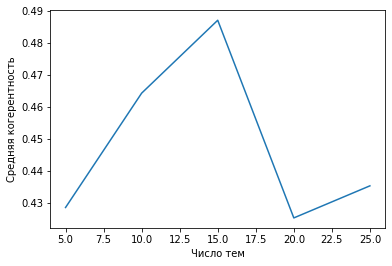

In [34]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Оптимальное число тем - 15

In [35]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Библиотека BigARTM

Теперь попробуем построить модели с помощью библиотеки BigARTM. [Тут](https://github.com/bigartm/bigartm-book/blob/master/ARTM_example_RU.ipynb) и [тут](https://github.com/bigartm/bigartm-book/blob/master/ARTM_tutorial_RU.ipynb) можно посмотреть на примеры использования библиотеки. 

### Установка библиотеки в Google Colab

In [ ]:
!apt-get --yes update
!apt-get --yes install git make cmake build-essential libboost-all-dev
!apt-get --yes install python-numpy python-pandas python-scipy
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py
!pip install protobuf tqdm wheel
!git clone --branch=stable https://github.com/bigartm/bigartm.git

In [37]:
%cd bigartm

/content/bigartm


In [38]:
!mkdir build

In [39]:
%cd build

/content/bigartm/build


In [ ]:
!cmake ..

In [ ]:
!make

In [ ]:
!make install

In [43]:
!pip install python/bigartm*.whl


Processing ./python/bigartm-0.10.0-cp37-cp37m-linux_x86_64.whl


### Тематические модели в BigARTM

In [44]:
import artm

In [45]:
artm.version()

'0.10.0'

In [46]:
artm.ARTM(num_topics=10).info

config {
  topic_name: "topic_0"
  topic_name: "topic_1"
  topic_name: "topic_2"
  topic_name: "topic_3"
  topic_name: "topic_4"
  topic_name: "topic_5"
  topic_name: "topic_6"
  topic_name: "topic_7"
  topic_name: "topic_8"
  topic_name: "topic_9"
  score_config {
    name: "^^^ItemsProcessedScore^^^"
    type: ScoreType_ItemsProcessed
    config: ""
  }
  pwt_name: "pwt"
  nwt_name: "nwt"
  num_document_passes: 10
  reuse_theta: false
  cache_theta: false
}
score {
  name: "^^^ItemsProcessedScore^^^"
  type: "N4artm5score14ItemsProcessedE"
}
processor_queue_size: 0
num_processors: 2

Чтобы работать с данными в библиотеке ARTM нужно сперва сделать препроцессинг (мы уже сделали его ранее) и записать данные в [одном из форматов](https://bigartm.readthedocs.io/en/v0.10.1/tutorials/datasets.html), с которыми умеет работать библиотека. Мы конвертируем данные в формат vowpal wabbit:

doc1 this text will be processed not as bag of words | Some_Author

In [47]:
data['text'] = data['text'].apply(lambda x: ' '.join(x))

In [48]:
i = 0
d = data.iloc[i]
d

title    Плющенко объявил о возобновлении карьеры                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
topic    Спорт                                                                                                                                                                                                                                                                                                                  

In [49]:
f'doc{i} {d.text} |topic {d.topic}'

'doc0 двукратный олимпийский чемпион евгений плющенко официально объявить возобновление спортивный карьера это фигурист сообщить беседа тасс потихонечку начинать тренироваться близкий время выйти соревнование заявить плющенко слово спортсмен планировать принять участие чемпионат мир европа год плющенко приостановить выступление официальный турнир олимпиада год сочи прошлый сезон летний фигурист участвовать пригласительный соревнование шоу также показательный выступление россиянин являться олимпийский чемпион фигурный катание год также выступать олимпиада плющенко неоднократно заявлять мочь принять участие пятый игра подряд который состояться год южнокорейский пхенчхан |topic Спорт'

In [50]:
def convert_to_vw_format(index, row):
    return f'doc{index} {row.text} |topic {row.topic}'

In [51]:
with open('lenta_wv.wv', 'w') as f:
    for index, row in data.iterrows():
        vw_string = convert_to_vw_format(index, row)
        f.write(vw_string)
        f.write('\n')

Далее нужно создать объект BatchVectorizer для данных, которые мы записали в формате vowpal wabbit:

In [52]:
batch_vectorizer = artm.BatchVectorizer(data_path='lenta_wv.wv', 
                                        data_format='vowpal_wabbit',
                                        target_folder='lenta_batches')

Попробуем обучить модель LDA для 10 тем:

In [53]:
%%time 
lda = artm.LDA(num_topics=10, alpha=0.1, beta=0.001, 
               cache_theta=True,
               num_document_passes=5, 
               dictionary=batch_vectorizer.dictionary)

lda.fit_offline(batch_vectorizer=batch_vectorizer, 
                num_collection_passes=10)

CPU times: user 35.6 s, sys: 398 ms, total: 36 s
Wall time: 20.4 s


- __fit_offline__ (офлайн алгоритм): много проходов по коллекции, один проход по документу, одно обновление матрицы $\Phi$ в конце прохода по коллекции. __Лучше использовать при работе с небольшой коллекцией__.


- __fit_online__ (онлайн алгоритм) : один проход по коллекции, несколько проходов по документу, несколько обновлений матрицы $\Phi$ в конце прохода по коллекции. __Лучше использовать при работе с большой коллекцией, или коллекцией с часто меняющимеся темами.__



Можем посмотреть на все значения перплексии (для каждой итерации по коллекции из num_collection_passes=10):

In [54]:
lda.perplexity_value

[51007.0859375,
 4777.2099609375,
 4436.21435546875,
 3948.54150390625,
 3541.04541015625,
 3267.22607421875,
 3087.892333984375,
 2961.604736328125,
 2866.994140625,
 2794.8203125]

In [55]:
np.log(lda.perplexity_last_value)

7.9355230946138136

Посмотрим на топ-10 токенов для каждой из тем:

In [56]:
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['год', 'это', 'процент', 'который', 'учёный', 'мочь', 'работа', 'система', 'исследование', 'свой']
Topic #1: ['год', 'матч', 'клуб', 'команда', 'это', 'сборная', 'который', 'чемпионат', 'свой', 'тренер']
Topic #2: ['который', 'человек', 'свой', 'москва', 'слово', 'акция', 'это', 'также', 'сообщать', 'заявить']
Topic #3: ['матч', 'мир', 'российский', 'который', 'это', 'первый', 'россия', 'чемпионат', 'год', 'сборная']
Topic #4: ['россия', 'год', 'это', 'российский', 'президент', 'заявить', 'глава', 'который', 'страна', 'решение']
Topic #5: ['это', 'россия', 'задержать', 'который', 'сообщать', 'дело', 'военный', 'область', 'самолёт', 'также']
Topic #6: ['суд', 'год', 'дело', 'который', 'это', 'свой', 'бывший', 'адвокат', 'решение', 'рубль']
Topic #7: ['это', 'человек', 'произойти', 'город', 'сообщать', 'который', 'дом', 'год', 'место', 'результат']
Topic #8: ['год', 'который', 'это', 'россия', 'тысяча', 'сообщать', 'время', 'стать', 'всё', 'человек']
Topic #9: ['год', 'компани

[Более подробный ноутбук про модель LDA](https://github.com/bigartm/bigartm-book/blob/master/LDA_tutorial_RU.ipynb)

Теперь построим базовую модель pLSA:

In [57]:
plsa = artm.ARTM(num_topics=10, 
                 dictionary=batch_vectorizer.dictionary)

Добавим расчет перплексии:

In [58]:
plsa.scores.add(artm.PerplexityScore(name='lenta_perplexity_score',
                 dictionary=batch_vectorizer.dictionary))

И TopTokensScore, чтобы взглянуть на самые вероятные слова в каждой теме:

In [59]:
plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

In [60]:
plsa.fit_offline(batch_vectorizer=batch_vectorizer,
                 num_collection_passes=20)

In [61]:
plsa.score_tracker['lenta_perplexity_score'].value

[50449.390625,
 4637.52734375,
 4134.5947265625,
 3604.412353515625,
 3258.26513671875,
 3048.574951171875,
 2908.73046875,
 2810.141357421875,
 2739.087158203125,
 2687.734375,
 2649.958251953125,
 2620.78955078125,
 2598.06396484375,
 2579.970703125,
 2565.2509765625,
 2552.995849609375,
 2542.600830078125,
 2533.384033203125,
 2525.39892578125,
 2518.577392578125]

In [62]:
for topic_name in plsa.topic_names:
    print (topic_name + ': ', plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['который', 'учёный', 'год', 'это', 'мочь', 'исследование']
topic_1:  ['матч', 'команда', 'клуб', 'сборная', 'год', 'чемпионат']
topic_2:  ['который', 'это', 'свой', 'человек', 'акция', 'слово']
topic_3:  ['мир', 'год', 'российский', 'это', 'который', 'победа']
topic_4:  ['россия', 'президент', 'это', 'год', 'российский', 'глава']
topic_5:  ['военный', 'самолёт', 'россия', 'который', 'год', 'сообщать']
topic_6:  ['год', 'дело', 'суд', 'который', 'это', 'рубль']
topic_7:  ['человек', 'произойти', 'сообщать', 'это', 'который', 'дом']
topic_8:  ['год', 'который', 'это', 'свой', 'the', 'тысяча']
topic_9:  ['год', 'компания', 'который', 'новый', 'это', 'игра']


Обратите внимание на слова с заглавной буквы: это поле topic из оригинальных данных.

Попробуем удалить из словаря слишком редкие и слишком частые токены:

In [63]:
batch_vectorizer.dictionary.filter(min_tf=10, max_tf=5000)

artm.Dictionary(name=0ab70044-fc05-4262-a7a3-4c98ebe27132, num_entries=11334)

In [64]:
plsa = artm.ARTM(num_topics=10, 
                 dictionary=batch_vectorizer.dictionary)
plsa.scores.add(artm.PerplexityScore(name='lenta_perplexity_score',
                dictionary=batch_vectorizer.dictionary))

plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', 
                                    num_tokens=6))
plsa.fit_offline(batch_vectorizer=batch_vectorizer, 
                 num_collection_passes=20)

In [65]:
plsa.score_tracker['lenta_perplexity_score'].value

[2883.905517578125,
 1080.8826904296875,
 991.96826171875,
 880.0733032226562,
 800.5048217773438,
 750.4404907226562,
 716.0914916992188,
 691.3729858398438,
 673.613525390625,
 661.4424438476562,
 653.5435791015625,
 648.3710327148438,
 644.92138671875,
 642.5337524414062,
 640.8209838867188,
 639.505859375,
 638.4454956054688,
 637.5762939453125,
 636.8831787109375,
 636.3275756835938]

Стало заметно лучше :)

In [66]:
for topic_name in plsa.topic_names:
    print (topic_name + ': ', plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['учёный', 'мочь', 'исследование', 'работа', 'время', 'новый']
topic_1:  ['матч', 'команда', 'клуб', 'сборная', 'чемпионат', 'счёт']
topic_2:  ['москва', 'человек', 'акция', 'слово', 'заявить', 'сайт']
topic_3:  ['мир', 'российский', 'первый', 'турнир', 'место', 'победа']
topic_4:  ['президент', 'глава', 'заявить', 'российский', 'путин', 'владимир']
topic_5:  ['военный', 'самолёт', 'российский', 'время', 'новый', 'сша']
topic_6:  ['дело', 'суд', 'рубль', 'уголовный', 'следствие', 'обвинение']
topic_7:  ['человек', 'произойти', 'район', 'сотрудник', 'погибнуть', 'данные']
topic_8:  ['летний', 'женщина', 'ребёнок', 'время', 'the', 'стать']
topic_9:  ['компания', 'игра', 'пользователь', 'новый', 'миллион', 'процент']


__Мультимодальные модели__

В библиотеке ARTM можно обучать мультимодальные модели, например, давайте попробуем обучить модель, которая будет учитывать поле topic из наших данных (мы специально записали его отдельно через | )

In [67]:
# описываем модель и задаем веса классов
martm = artm.ARTM(num_topics=20,
                  class_ids={'@default_class': 1.0, '@topic': 5.0}, 
                  dictionary=batch_vectorizer.dictionary)

Добавим расчет метрик и регуляризаторы:

In [68]:
martm.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score',
                                       class_id='@topic'))

martm.scores.add(artm.TopTokensScore(name='TopTokensScore',
                                     num_tokens=6))


martm.scores.add(artm.PerplexityScore(name='lenta_perplexity_score',
                dictionary=batch_vectorizer.dictionary))

martm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_def',
                    class_ids=['@default_class']))

martm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_lab',
                        class_ids=['@topic']))

In [69]:
martm.fit_offline(batch_vectorizer=batch_vectorizer, 
                  num_collection_passes=10)

In [70]:
martm.score_tracker['lenta_perplexity_score'].value

[3085.337890625,
 1133.642578125,
 1001.45068359375,
 841.2515258789062,
 741.8577270507812,
 686.814208984375,
 655.4490356445312,
 635.9358520507812,
 622.9281616210938,
 613.8133544921875]

In [71]:
for topic_name in martm.topic_names:
    print (topic_name + ': ', martm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['учёный', 'мочь', 'исследование', 'новый', 'работа', 'время']
topic_1:  ['клуб', 'матч', 'команда', 'сборная', 'чемпионат', 'тренер']
topic_2:  ['человек', 'ребёнок', 'процент', 'слово', 'весь', 'женщина']
topic_3:  ['российский', 'страна', 'международный', 'сша', 'президент', 'заявить']
topic_4:  ['закон', 'российский', 'организация', 'документ', 'заявить', 'страна']
topic_5:  ['самолёт', 'военный', 'ракета', 'вертолёт', 'новый', 'оборона']
topic_6:  ['игра', 'проект', 'новый', 'выйти', 'фильм', 'первый']
topic_7:  ['произойти', 'человек', 'пострадать', 'москва', 'находиться', 'город']
topic_8:  ['тысяча', 'деньга', 'летний', 'издание', 'газета', 'полиция']
topic_9:  ['президент', 'путин', 'владимир', 'глава', 'заявить', 'слово']
topic_10:  ['суд', 'дело', 'рубль', 'миллион', 'решение', 'бывший']
topic_11:  ['пользователь', 'интернет', 'сайт', 'сеть', 'опубликовать', 'сервис']
topic_12:  ['дело', 'задержать', 'убийство', 'уголовный', 'статья', 'полиция']
topic_13:  ['животн

Сравним обычную модель pLSA и модель mARTM:

In [72]:
model_plsa = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(20)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                       dictionary=batch_vectorizer.dictionary)],
                       cache_theta=True)

model_martm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(20)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                       dictionary=batch_vectorizer.dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)],
                       cache_theta=True,
                        class_ids={'@default_class': 1.0, '@topic': 5.0}, 
                  dictionary=batch_vectorizer.dictionary)

In [73]:
model_martm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_martm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))

In [74]:
model_plsa.initialize(dictionary=batch_vectorizer.dictionary)
model_martm.initialize(dictionary=batch_vectorizer.dictionary)

In [75]:
model_martm.num_document_passes = 1
model_plsa.num_document_passes = 1

model_martm.fit_offline(batch_vectorizer=batch_vectorizer, 
                        num_collection_passes=20)
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer,
                       num_collection_passes=20)

Perplexity: 781.147 (pLSA) vs. 822.612 (mARTM)


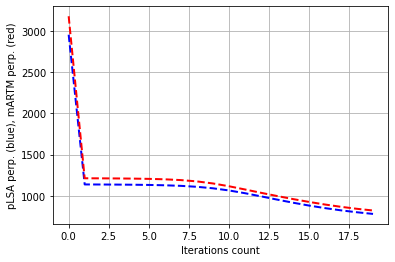

In [76]:
import matplotlib.pyplot as plt

def print_measures(model_plsa, model_martm):

    print ('Perplexity: {0:.3f} (pLSA) vs. {1:.3f} (mARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_martm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_martm.num_phi_updates), model_martm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    
    plt.xlabel('Iterations count')
    plt.ylabel('pLSA perp. (blue), mARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(model_plsa, model_martm)